In [1]:
pip install --upgrade pandas

Note: you may need to restart the kernel to use updated packages.


In [4]:
import os
import numpy as np
import tensorflow as tf
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow.keras import models, layers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report

In [8]:
# Define dataset paths
test_dir = r"C:\Users\user\Downloads\FruitinAmazon\FruitinAmazon\test"
train_dir = r"C:\Users\user\Downloads\FruitinAmazon\FruitinAmazon\train"

In [10]:
# Get the list of class directories (categories)
class_names = [d for d in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, d))]

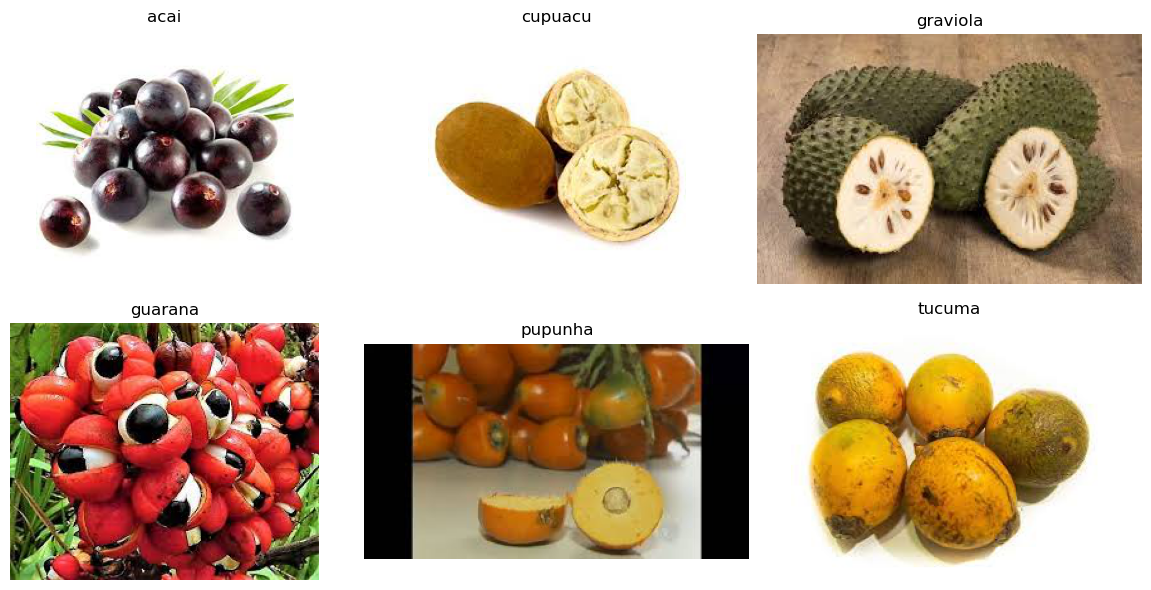

In [12]:
# Select one random image from each class
sample_images = []
labels = []

import random

for class_name in class_names:
    class_path = os.path.join(train_dir, class_name)
    image_files = os.listdir(class_path)
    
    if image_files:  # Ensure the class folder is not empty
        random_image = random.choice(image_files)
        image_path = os.path.join(class_path, random_image)
        sample_images.append(image_path)
        labels.append(class_name)

# Display images in a grid format with two rows
num_classes = len(sample_images)
cols = num_classes // 2 if num_classes >= 2 else num_classes  # Ensuring at least 2 rows
rows = 2  # Two-row grid

fig, axes = plt.subplots(rows, cols, figsize=(12, 6))

# Flatten the axes if necessary
axes = axes.flatten() if num_classes > 1 else [axes]

for ax, img_path, label in zip(axes, sample_images, labels):
    img = Image.open(img_path)
    ax.imshow(img)
    ax.set_title(label)
    ax.axis("off")

plt.tight_layout()
plt.show()

In [14]:
# List to store corrupted image paths
corrupted_images = []

# Iterate through each class subdirectory
for class_name in os.listdir(train_dir):
    class_path = os.path.join(train_dir, class_name)
    
    if os.path.isdir(class_path):  # Ensure it's a directory
        for image_file in os.listdir(class_path):
            image_path = os.path.join(class_path, image_file)
            try:
                with Image.open(image_path) as img:
                    img.verify()  # Verify if the image can be opened
            except (IOError, SyntaxError):
                corrupted_images.append(image_path)
                os.remove(image_path)
                print(f"Removed corrupted image: {image_path}")

# Print summary
if not corrupted_images:
    print("No Corrupted Images Found.")


No Corrupted Images Found.


In [20]:
# Define image size and batch size
img_height = 128 # Example image height
img_width = 128 # Example image width
batch_size = 16
validation_split = 0.2 # 80% training, 20% validation
# Create a preprocessing layer for normalization
rescale = tf.keras.layers.Rescaling(1./255) # Normalize pixel values to [0, 1]
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='int',
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=True,
    validation_split=0.2,
    subset='training',
    seed=123
)

# Store class names before mapping
class_names = train_ds.class_names

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    labels='inferred',
    label_mode='int',
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=False,
    validation_split=0.2,
    subset='validation',
    seed=123
).map(lambda x, y: (x / 255.0, y))  # Normalize images

Found 90 files belonging to 6 classes.
Using 72 files for training.
Found 30 files belonging to 6 classes.
Using 6 files for validation.


In [22]:
def create_cnn_model(input_shape, num_classes):
    model = models.Sequential([
        # Convolutional Layer 1
        layers.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=input_shape),

        #Pooling Layer 1
        layers.MaxPooling2D((2, 2)),

        # Convolutional Layer 2
        layers.Conv2D(64, (3, 3), padding='same', activation='relu'),

        #Pooling Layer 2
        layers.MaxPooling2D((2, 2)),

        # Flatten Layer
        layers.Flatten(),

        # Fully Connected Network Architecture
        layers.Dense(64, activation='relu'), 
        layers.Dense(128, activation='relu'), 

        # Output Layer
        layers.Dense(num_classes, activation='softmax')
    ])
    
    return model

# Ensure input shape matches dataset
input_shape = (128, 128, 3) 
num_classes = 6

model = create_cnn_model(input_shape, num_classes)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Print model summary to verify shapes
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 65536)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │     4,194,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,222,854 (16.11 MB)

 Trainable params: 4,222,854 (16.11 MB)

 Non-trainable params: 0 (0.00 B)

In [29]:
# Callbacks to avoid overfitting and save the best model
checkpoint_cb = ModelCheckpoint("best_model.keras", save_best_only=True, monitor='val_loss', mode='min')
early_stopping_cb = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [30]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=250,  # Number of training epochs
    batch_size=batch_size,
    callbacks=[checkpoint_cb, early_stopping_cb]
)

Epoch 1/250
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 976ms/step - accuracy: 1.0000 - loss: 7.7287e-05 - val_accuracy: 0.6667 - val_loss: 1.7460
Epoch 2/250
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 191ms/step - accuracy: 1.0000 - loss: 6.6096e-05 - val_accuracy: 0.6667 - val_loss: 1.7462
Epoch 3/250
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 183ms/step - accuracy: 1.0000 - loss: 7.8922e-05 - val_accuracy: 0.6667 - val_loss: 1.7463
Epoch 4/250
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 167ms/step - accuracy: 1.0000 - loss: 6.3158e-05 - val_accuracy: 0.6667 - val_loss: 1.7464
Epoch 5/250
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 168ms/step - accuracy: 1.0000 - loss: 4.2202e-05 - val_accuracy: 0.6667 - val_loss: 1.7466
Epoch 6/250
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 174ms/step - accuracy: 1.0000 - loss: 4.0788e-05 - val_accuracy: 0.6667 - val_loss: 1.7467
Epoch 7/250
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 174ms/step - accuracy: 1.0000 - loss: 4.9962e-05 - val_accuracy: 0.6667 - val_loss: 1.7468
Epoch 8/250
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 175ms/step - accuracy: 1.0000 - loss: 5.863

In [32]:
test_loss, test_acc = model.evaluate(val_ds)

print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.6667 - loss: 1.7460
Test Accuracy: 0.6667
Test Loss: 1.7460


In [33]:
model.save("best_model.keras")

In [34]:
# Load the saved model
loaded_model = tf.keras.models.load_model("best_model.keras", compile=False)
loaded_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Re-evaluate the loaded model
test_loss, test_acc = loaded_model.evaluate(val_ds)

print(f"Reloaded Model Test Accuracy: {test_acc:.4f}")
print(f"Reloaded Model Test Loss: {test_loss:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.6667 - loss: 1.7460
Reloaded Model Test Accuracy: 0.6667
Reloaded Model Test Loss: 1.7460


In [35]:
# Get the true labels from the validation dataset
y_true = np.concatenate([y for _, y in val_ds], axis=0)

# Predict the probabilities for the validation dataset
y_pred_probs = loaded_model.predict(val_ds)

# Convert the predicted probabilities to class labels
y_pred = np.argmax(y_pred_probs, axis=1)

# Get the class names from the training dataset (train_ds)
class_names = train_ds.class_names  # Ensure class_names reflect the correct class names

# Print the number of classes and check the consistency
print(f"Number of classes: {len(class_names)}")
print(f"Class names: {class_names}")

# Ensure the number of labels in the classification report matches the number of classes
# Generate the classification report by passing 'labels' to ensure consistency
report = classification_report(y_true, y_pred, target_names=class_names, labels=np.arange(len(class_names)), zero_division=1)
print(report)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
Number of classes: 6
Class names: ['acai', 'cupuacu', 'graviola', 'guarana', 'pupunha', 'tucuma']
              precision    recall  f1-score   support

        acai       1.00      1.00      1.00         0
     cupuacu       0.00      1.00      0.00         0
    graviola       1.00      1.00      1.00         0
     guarana       1.00      1.00      1.00         0
     pupunha       0.50      1.00      0.67         1
      tucuma       1.00      0.60      0.75         5

    accuracy                           0.67         6
   macro avg       0.75      0.93      0.74         6
weighted avg       0.92      0.67      0.74         6



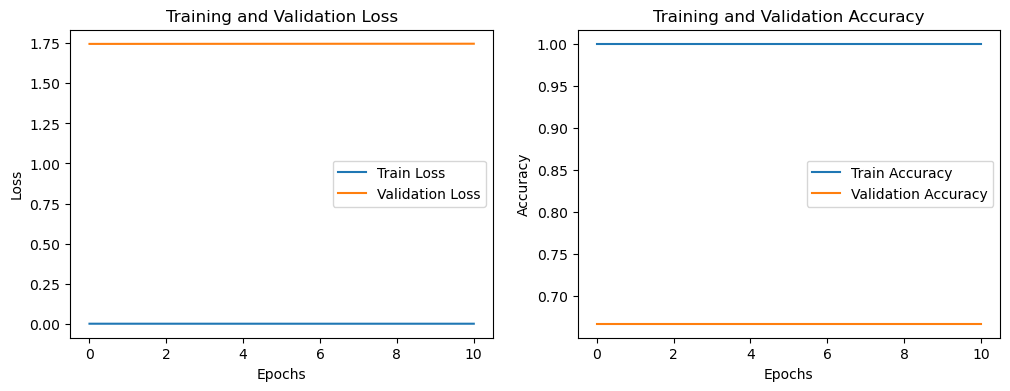

In [36]:
# Plot Training History
plt.figure(figsize=(12, 4))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.show()
